In [ ]:
import warnings
warnings.filterwarnings("ignore")
import sys
import numpy as np
import pandas as pd
import dynamo as dyn
import scanpy as sc
import scvelo as scv

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
sys.path.append('../../../graphvelo')
from utils import adj_to_knn
from graph_velocity import GraphVelo
from plot import gene_trend, cbc_heatmap
from metrics import cross_boundary_correctness

In [3]:
cmap = {'G1-S':'firebrick', 'S':'orange', 'G2-M':'yellowgreen', 'M':'teal', 'M-G1':'royalblue'}

In [4]:
adata = sc.read('data/fucci_U2OS.h5ad')
adata

AnnData object with n_obs × n_vars = 1146 × 19997
    obs: 'Well_Plate', 'plate', 'phase', 'MeanGreen530', 'MeanRed585', 'fucci_time', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size'
    var: 'name', 'biotype', 'description', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'GeneName'
    layers: 'ambiguous', 'matrix', 'spanning', 'spliced', 'unspliced'

In [5]:
adata_dyn = adata.copy()
adata_scv = adata.copy()

In [ ]:
def dynamo_criteria(adata):
    dyn.pp.recipe_monocle(adata)
    dyn.tl.neighbors(adata)
    dyn.tl.dynamics(adata)
    dyn.tl.reduceDimension(adata)
    dyn.tl.cell_velocities(adata)
    dyn.pl.streamline_plot(adata, color=['cell_cycle_phase'], basis='umap')

def scvelo_criteria(adata):
    scv.pp.filter_and_normalize(
        adata, min_shared_counts=20, n_top_genes=2000, subset_highly_variable=False
    )
    sc.tl.pca(adata)
    sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30, random_state=0)
    scv.pp.moments(adata, n_pcs=None, n_neighbors=None)
    sc.tl.umap(adata)
    scv.tl.recover_dynamics(adata, n_jobs=4)
    scv.tl.velocity(adata, mode="dynamical")
    scv.tl.latent_time(adata)
    scv.tl.velocity_graph(adata)

|-----? dynamo.preprocessing.deprecated is deprecated.
|-----> recipe_monocle_keep_filtered_cells_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_cells_key=True
|-----> recipe_monocle_keep_filtered_genes_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_genes_key=True
|-----> recipe_monocle_keep_raw_layers_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_raw_layers_key=True
|-----> apply Monocole recipe to adata...
|-----> convert ensemble name to official gene name
|-----? Your adata object uses non-official gene names as gene index. 
Dynamo is converting those names to official gene names.
|-----> Storing myGene name info into local cache db: mygene_cache.sqlite.


1 input query terms found dup hits:	[('ENSG00000268674', 3)]
101 input query terms found no hit:	['ENSG00000112096', 'ENSG00000130489', 'ENSG00000130723', 'ENSG00000139656', 'ENSG00000168078', 'ENS


|-----> Subsetting adata object and removing Nan columns from adata when converting gene names.
|-----> ensure all cell and variable names unique.
|-----> ensure all data in different layers in csr sparse matrix format.
|-----> ensure all labeling data properly collapased
|-----> filtering cells...
|-----> 1146 cells passed basic filters.
|-----> filtering gene...
|-----> 11819 genes passed basic filters.
|-----> calculating size factor...
|-----> selecting genes in layer: X, sort method: SVR...
|-----> size factor normalizing the data, followed by log1p transformation.
|-----> Set <adata.X> to normalized data
|-----> applying PCA ...
|-----> <insert> X_pca to obsm in AnnData Object.
|-----> cell cycle scoring...
|-----> computing cell phase...
|-----> [Cell Phase Estimation] completed [19.3759s]
|-----> [Cell Cycle Scores Estimation] completed [0.0687s]
|-----> [recipe_monocle preprocess] completed [8.6602s]
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetch

estimating gamma: 100%|██████████| 2000/2000 [00:12<00:00, 164.32it/s]


|-----> retrieve data for non-linear dimension reduction...
|-----> [UMAP] using X_pca with n_pca_components = 30
|-----> <insert> X_umap to obsm in AnnData Object.
|-----> [UMAP] completed [3.6867s]
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via pearson kernel with sqrt transform.] completed [1.2593s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.1722s]
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----------> plotting with basis key=X_umap
|-----------> skip filtering cell_cycle_phase by stack threshold when stacking color because it is not a numeric type


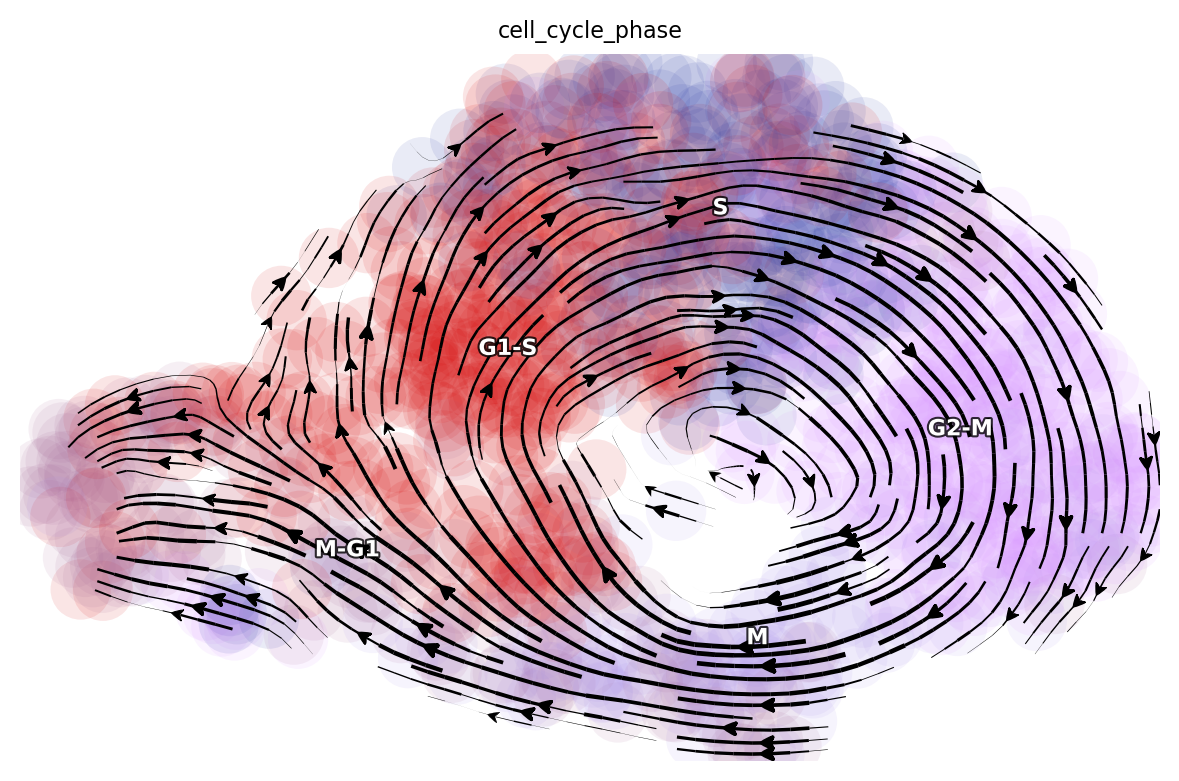

In [7]:
dynamo_criteria(adata_dyn)

|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----------> plotting with basis key=X_umap
|-----------> skip filtering cell_cycle_phase by stack threshold when stacking color because it is not a numeric type


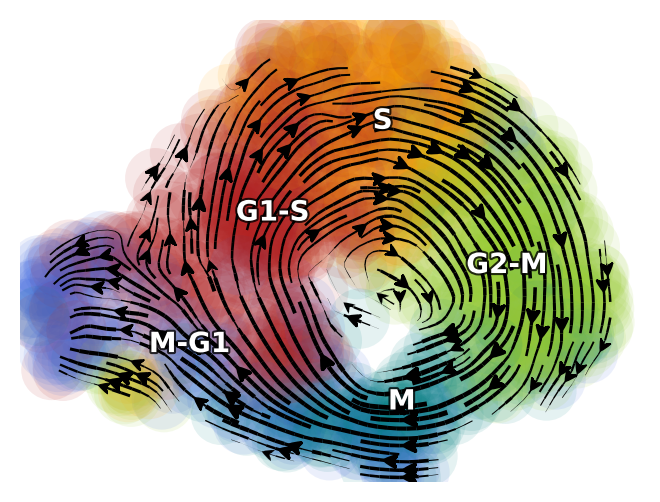

In [40]:
ax = dyn.pl.streamline_plot(adata_dyn, color=['cell_cycle_phase'], color_key=cmap, save_show_or_return='return', figsize=(4,3))
plt.title('')
plt.savefig(dpi=300, transparent=True, fname=f'./figures/fucci_dyn.svg', bbox_inches = "tight")
plt.show()

Filtered out 7591 genes that are detected 20 counts (shared).
Normalized count data: spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.


/opt/anaconda3/envs/graphvelo/lib/python3.8/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 4/10 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:29) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/10 cores)
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 0 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time

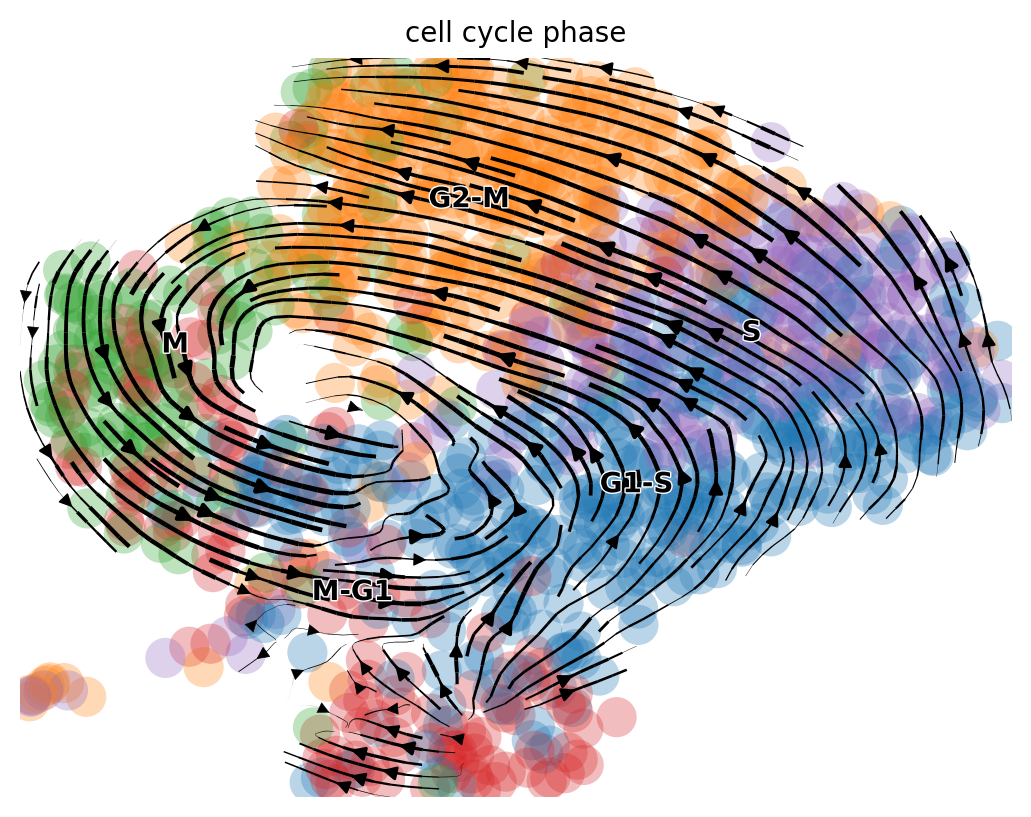

In [ ]:
adata_scv.obs['cell_cycle_phase'] = adata_dyn.obs['cell_cycle_phase'].copy()
adata_scv.uns['cell_cycle_phase_colors'] = adata_dyn.uns['cell_cycle_phase_colors'].copy()
scvelo_criteria(adata_scv)
scv.pl.velocity_embedding_stream(adata_scv, color='cell_cycle_phase')

|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----------> plotting with basis key=X_umap
|-----------> skip filtering cell_cycle_phase by stack threshold when stacking color because it is not a numeric type


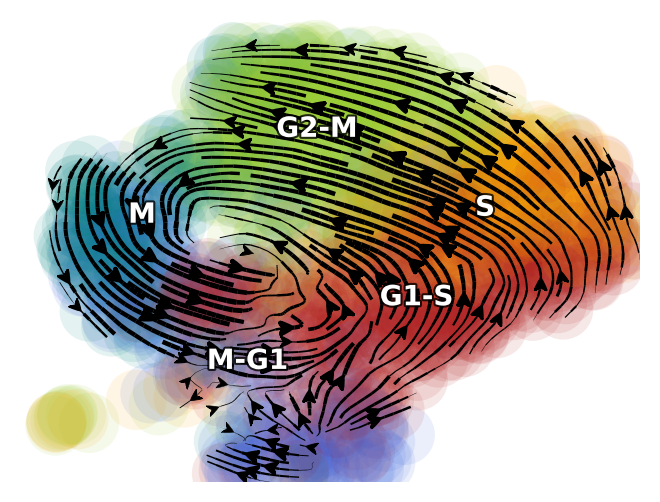

In [41]:
ax = dyn.pl.streamline_plot(adata_scv, color=['cell_cycle_phase'], color_key=cmap, save_show_or_return='return', figsize=(4,3))
plt.title('')
plt.savefig(dpi=300, transparent=True, fname=f'./figures/fucci_scv.svg', bbox_inches = "tight")
plt.show()

In [ ]:
gv_dyn = GraphVelo(adata_dyn, gene_subset=adata_dyn[:, adata_dyn.var['use_for_transition']].var_names, xkey='M_s', vkey='velocity_S')
gv_dyn.train()
adata_dyn.layers['velocity_gv'] = gv_dyn.project_velocity(adata_dyn.layers['M_s'])
adata_dyn.obsm['gv_pca'] = gv_dyn.project_velocity(adata_dyn.obsm['X_pca'])
adata_dyn.obsm['gv_umap'] = gv_dyn.project_velocity(adata_dyn.obsm['X_umap'])

Learning Phi in tangent space projection.: 100%|██████████| 1146/1146 [00:01<00:00, 596.28it/s]
projecting velocity vector to low dimensional embedding: 100%|██████████| 1146/1146 [00:02<00:00, 541.60it/s]
projecting velocity vector to low dimensional embedding: 100%|██████████| 1146/1146 [00:00<00:00, 16424.70it/s]
projecting velocity vector to low dimensional embedding: 100%|██████████| 1146/1146 [00:00<00:00, 14870.38it/s]


|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----------> plotting with basis key=X_umap
|-----------> skip filtering cell_cycle_phase by stack threshold when stacking color because it is not a numeric type


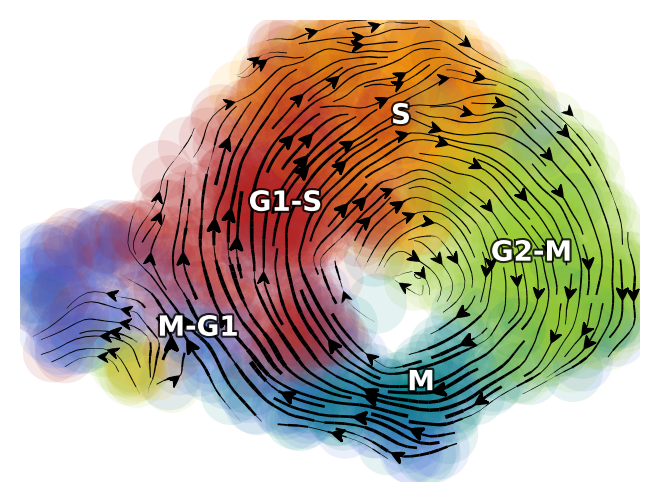

In [42]:
ax = dyn.pl.streamline_plot(adata_dyn, color=['cell_cycle_phase'], vector='gv', color_key=cmap, save_show_or_return='return', figsize=(4,3))
plt.title('')
plt.savefig(dpi=300, transparent=True, fname=f'./figures/fucci_gv_dyn.svg', bbox_inches = "tight")
plt.show()

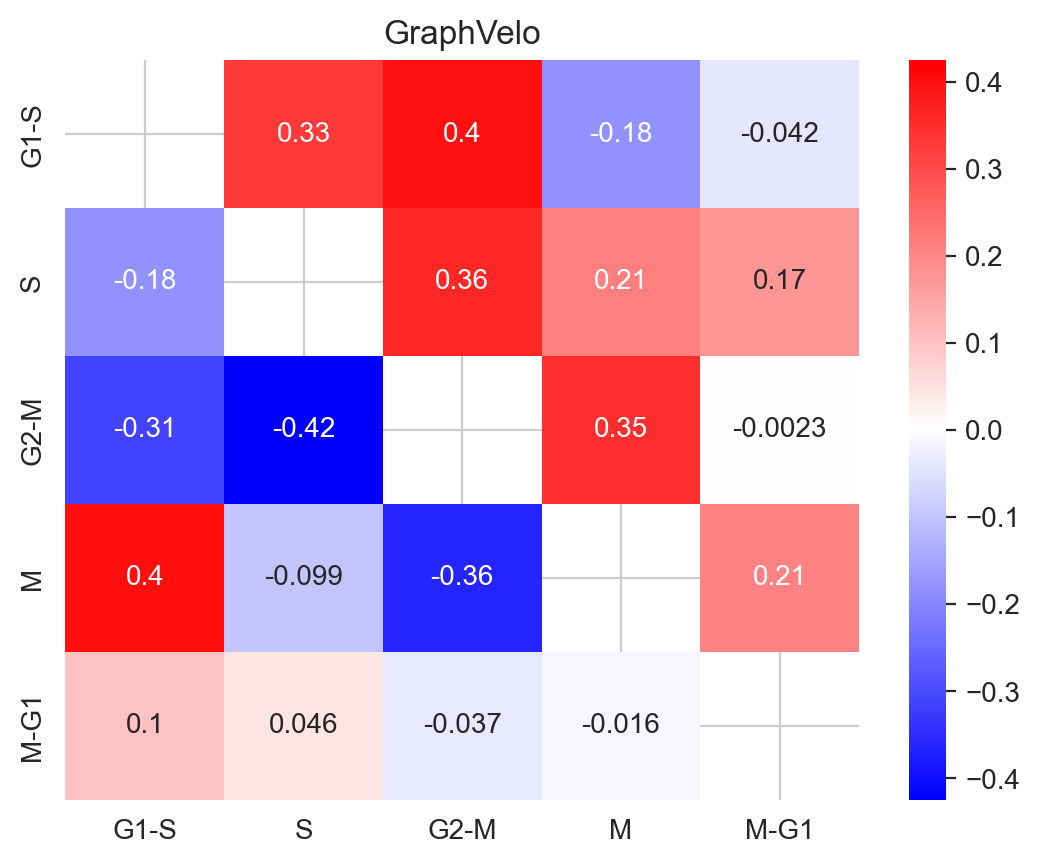

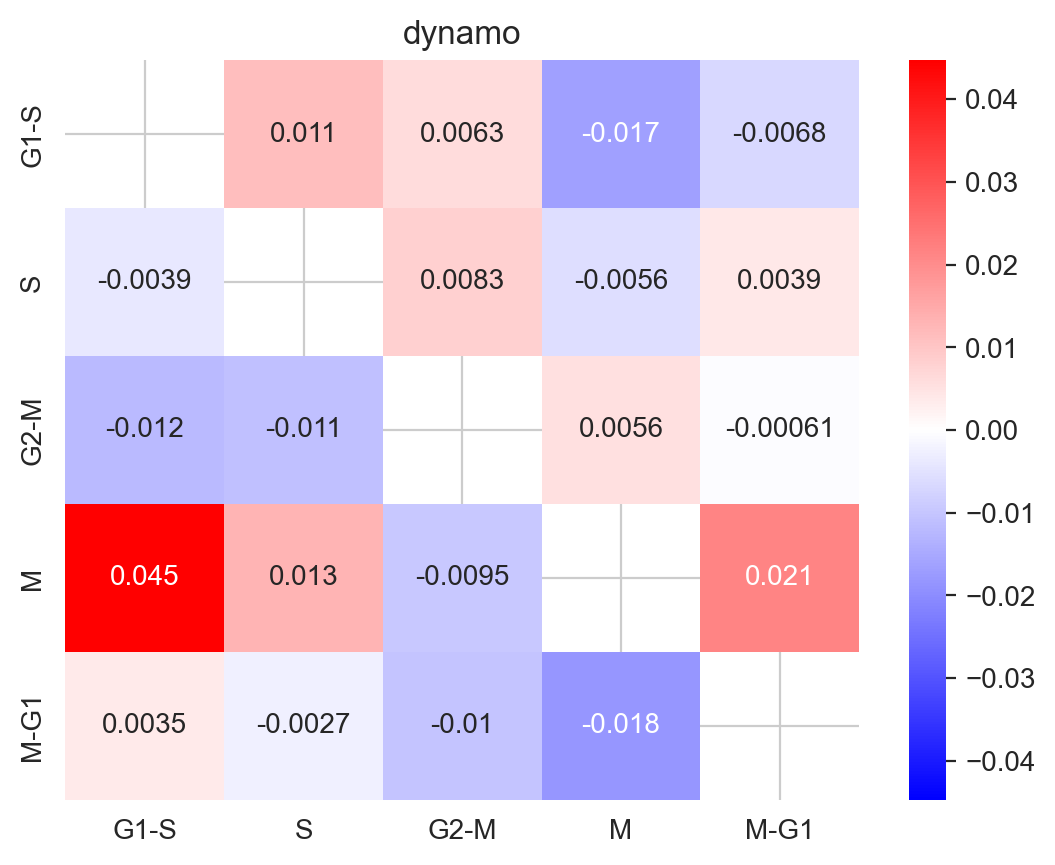

In [43]:
cbc_heatmap(adata_dyn, xkey='M_s', vkey='velocity_gv', cluster_key='cell_cycle_phase', basis='raw', vector='gv', custom_order=['G1-S', 'S', 'G2-M', 'M', 'M-G1'])
plt.title('GraphVelo')
plt.savefig(dpi=300, transparent=True, fname=f'./figures/fucci_gv_dyn_cbcheatmap.pdf', bbox_inches = "tight")
plt.show()
cbc_heatmap(adata_dyn, xkey='M_s', vkey='velocity_S', cluster_key='cell_cycle_phase', basis='raw', custom_order=['G1-S', 'S', 'G2-M', 'M', 'M-G1'])
plt.title('dynamo')
plt.savefig(dpi=300, transparent=True, fname=f'./figures/fucci_dyn_cbcheatmap.pdf', bbox_inches = "tight")
plt.show()

In [ ]:
indices, _ = adj_to_knn(adata_scv.obsp['connectivities'])
adata_scv.uns['neighbors']['indices'] = indices
gv_scv = GraphVelo(adata_scv, gene_subset=adata_scv[:, adata_scv.var['velocity_genes']].var_names)
gv_scv.train()
adata_scv.layers['velocity_gv'] = gv_scv.project_velocity(adata_scv.layers['Ms'])
adata_scv.obsm['gv_pca'] = gv_scv.project_velocity(adata_scv.obsm['X_pca'])
adata_scv.obsm['gv_umap'] = gv_scv.project_velocity(adata_scv.obsm['X_umap'])

Learning Phi in tangent space projection.: 100%|██████████| 1146/1146 [00:00<00:00, 2248.36it/s]
projecting velocity vector to low dimensional embedding: 100%|██████████| 1146/1146 [00:01<00:00, 737.10it/s]
projecting velocity vector to low dimensional embedding: 100%|██████████| 1146/1146 [00:00<00:00, 12761.68it/s]
projecting velocity vector to low dimensional embedding: 100%|██████████| 1146/1146 [00:00<00:00, 13499.35it/s]


|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----------> plotting with basis key=X_umap
|-----------> skip filtering cell_cycle_phase by stack threshold when stacking color because it is not a numeric type


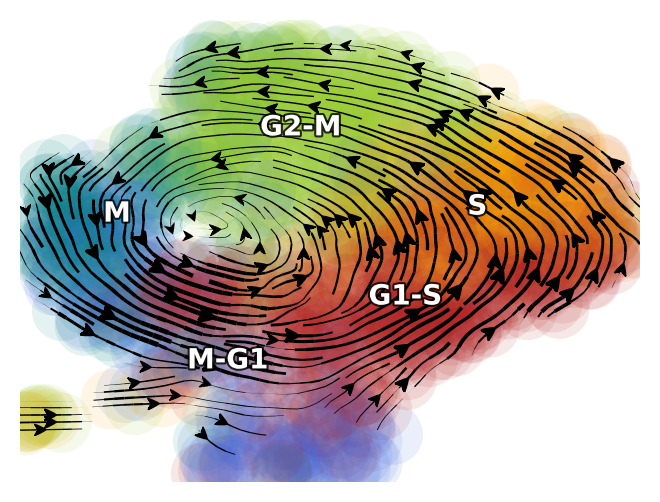

In [ ]:
# scv.pl.velocity_embedding_stream(adata_scv, color='cell_cycle_phase', X=adata_scv.obsm['X_umap'], V=adata_scv.obsm['gv_umap'])
ax = dyn.pl.streamline_plot(adata_scv, color=['cell_cycle_phase'], vector='gv', color_key=cmap, save_show_or_return='return', figsize=(4,3))
plt.title('')
plt.savefig(dpi=300, transparent=True, fname=f'./figures/fucci_gv_scv.svg', bbox_inches = "tight")
plt.show()

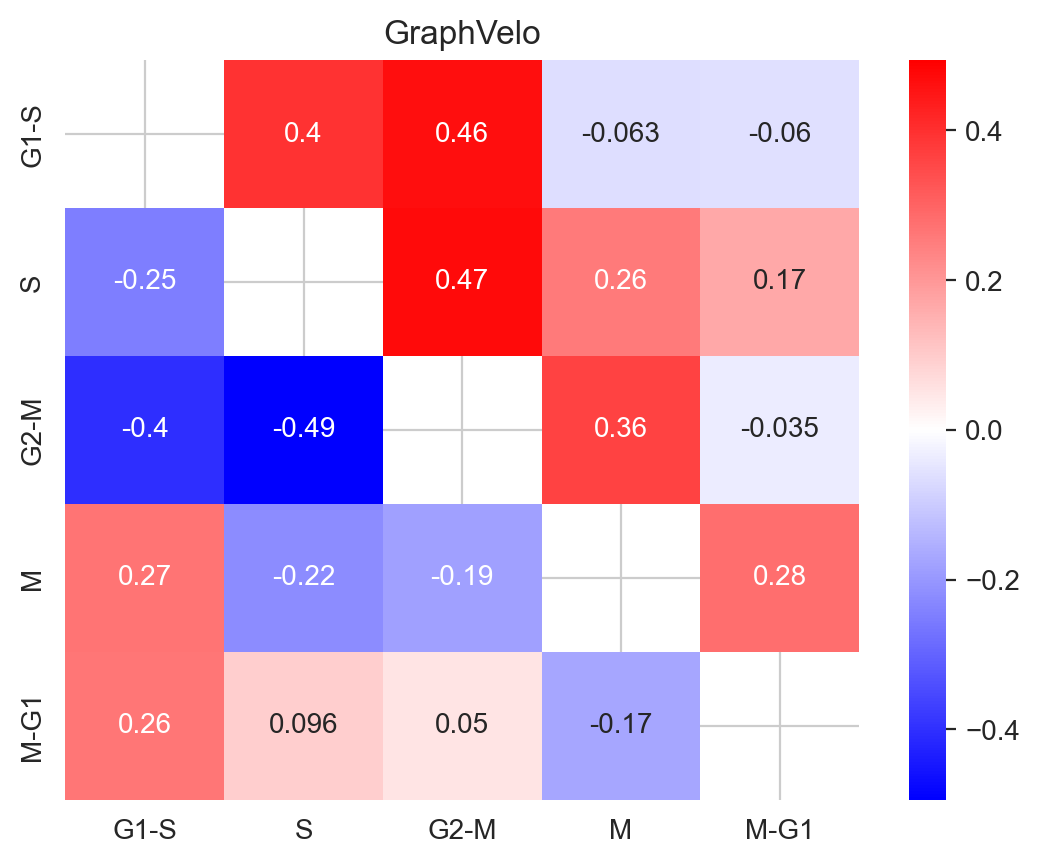

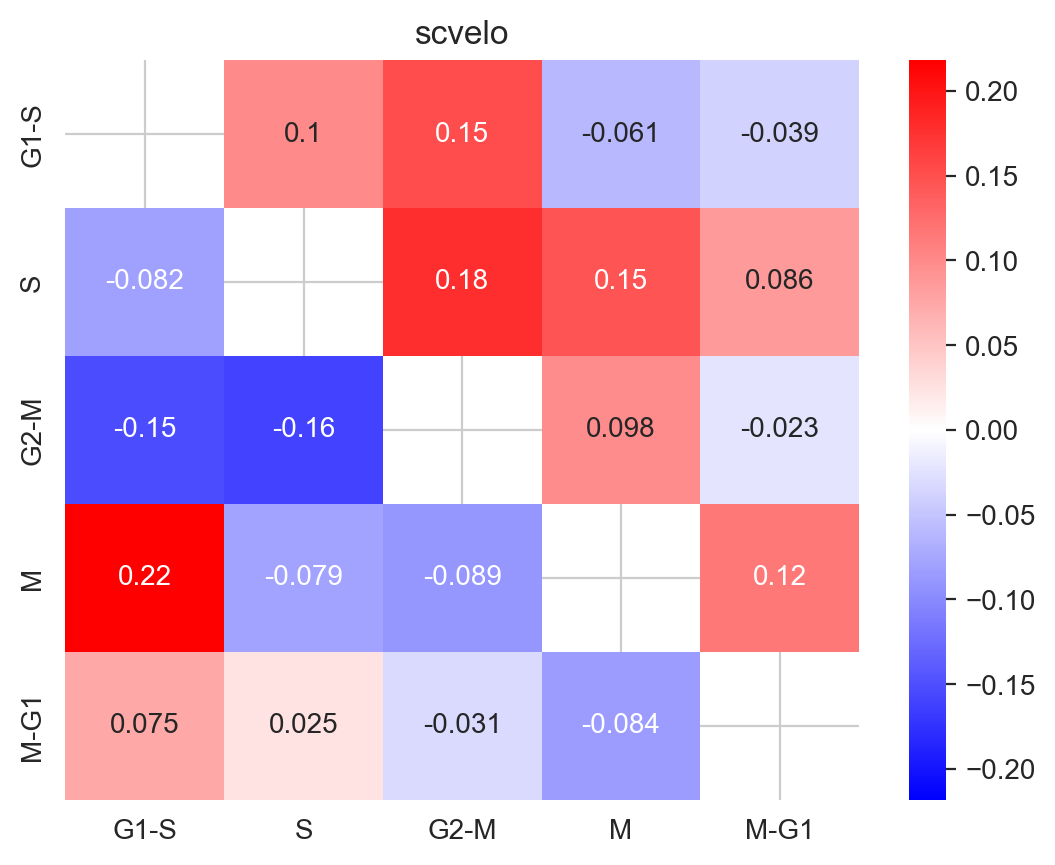

In [45]:
cbc_heatmap(adata_scv, xkey='Ms', vkey='velocity_gv', cluster_key='cell_cycle_phase', basis='raw', vector='gv', custom_order=['G1-S', 'S', 'G2-M', 'M', 'M-G1'])
plt.title('GraphVelo')
plt.savefig(dpi=300, transparent=True, fname=f'./figures/fucci_gv_scv_cbcheatmap.pdf', bbox_inches = "tight")
plt.show()
cbc_heatmap(adata_scv, xkey='Ms', vkey='velocity', cluster_key='cell_cycle_phase', basis='raw', custom_order=['G1-S', 'S', 'G2-M', 'M', 'M-G1'])
plt.title('scvelo')
plt.savefig(dpi=300, transparent=True, fname=f'./figures/fucci_scv_cbcheatmap.pdf', bbox_inches = "tight")
plt.show()

# Cell speed analysis

|-----------> plotting with basis key=X_umap


/opt/anaconda3/envs/graphvelo/lib/python3.8/site-packages/dynamo/plot/utils.py:626: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_ = copy.copy(matplotlib.cm.get_cmap(cmap))
/opt/anaconda3/envs/graphvelo/lib/python3.8/site-packages/dynamo/plot/utils.py:806: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()
/opt/anaconda3/envs/graphvelo/lib/python3.8/site-packages/dynamo/plot/utils.py:810: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap(cmap)
/opt/anaconda3/envs/graphvelo/lib/pyt

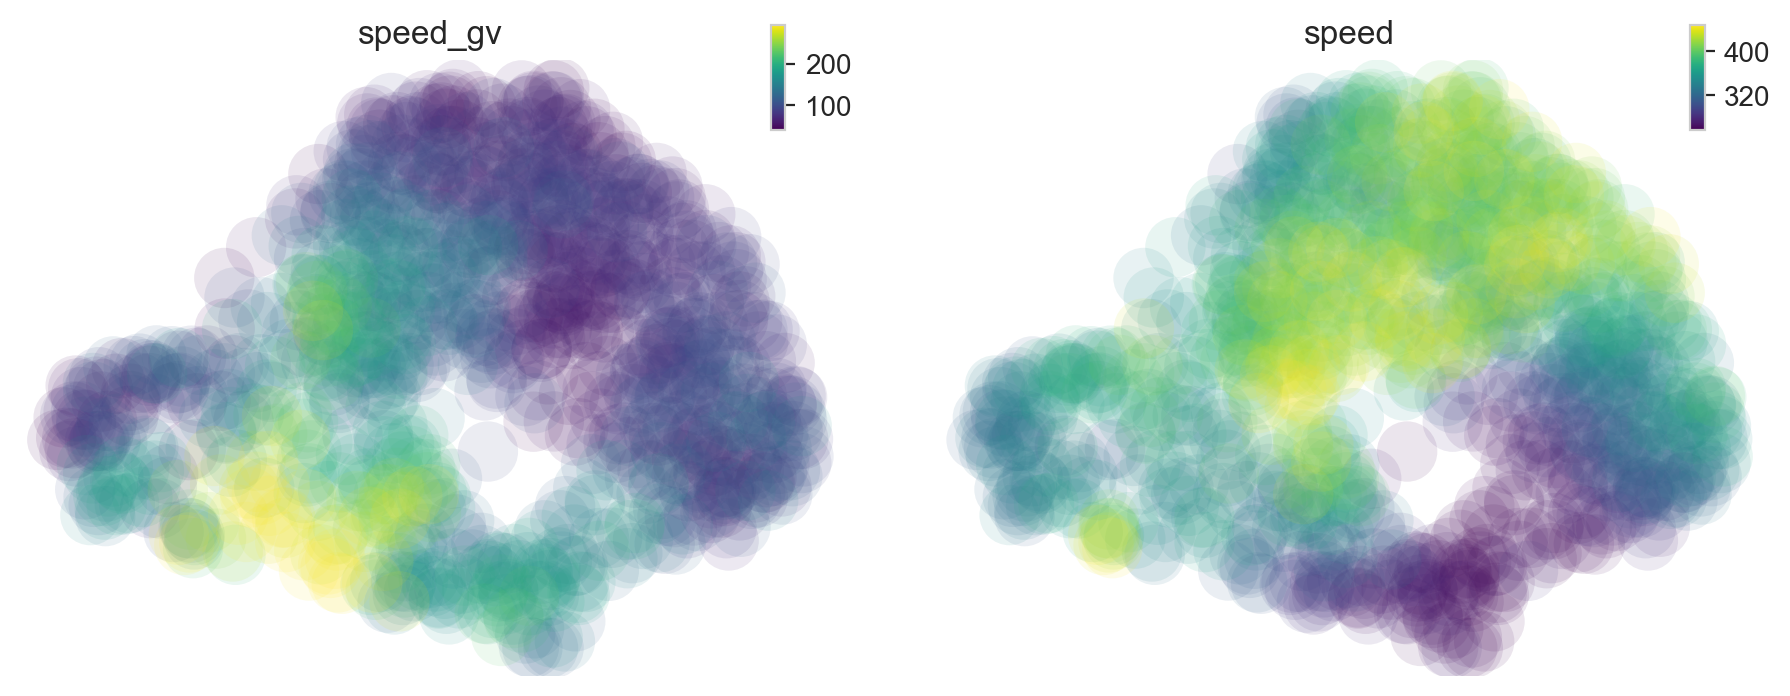

In [14]:
adata_dyn.obs['speed_gv'] = np.linalg.norm(adata_dyn.layers['velocity_gv'].A, axis=1)
adata_dyn.obs['speed'] = np.linalg.norm(adata_dyn.layers['velocity_S'].A, axis=1)
dyn.pl.scatters(adata_dyn, color=['speed_gv', 'speed'])

|-----------> plotting with basis key=X_umap


/opt/anaconda3/envs/graphvelo/lib/python3.8/site-packages/dynamo/plot/utils.py:626: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_ = copy.copy(matplotlib.cm.get_cmap(cmap))
/opt/anaconda3/envs/graphvelo/lib/python3.8/site-packages/dynamo/plot/utils.py:806: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()
/opt/anaconda3/envs/graphvelo/lib/python3.8/site-packages/dynamo/plot/utils.py:810: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap(cmap)
/opt/anaconda3/envs/graphvelo/lib/pyt

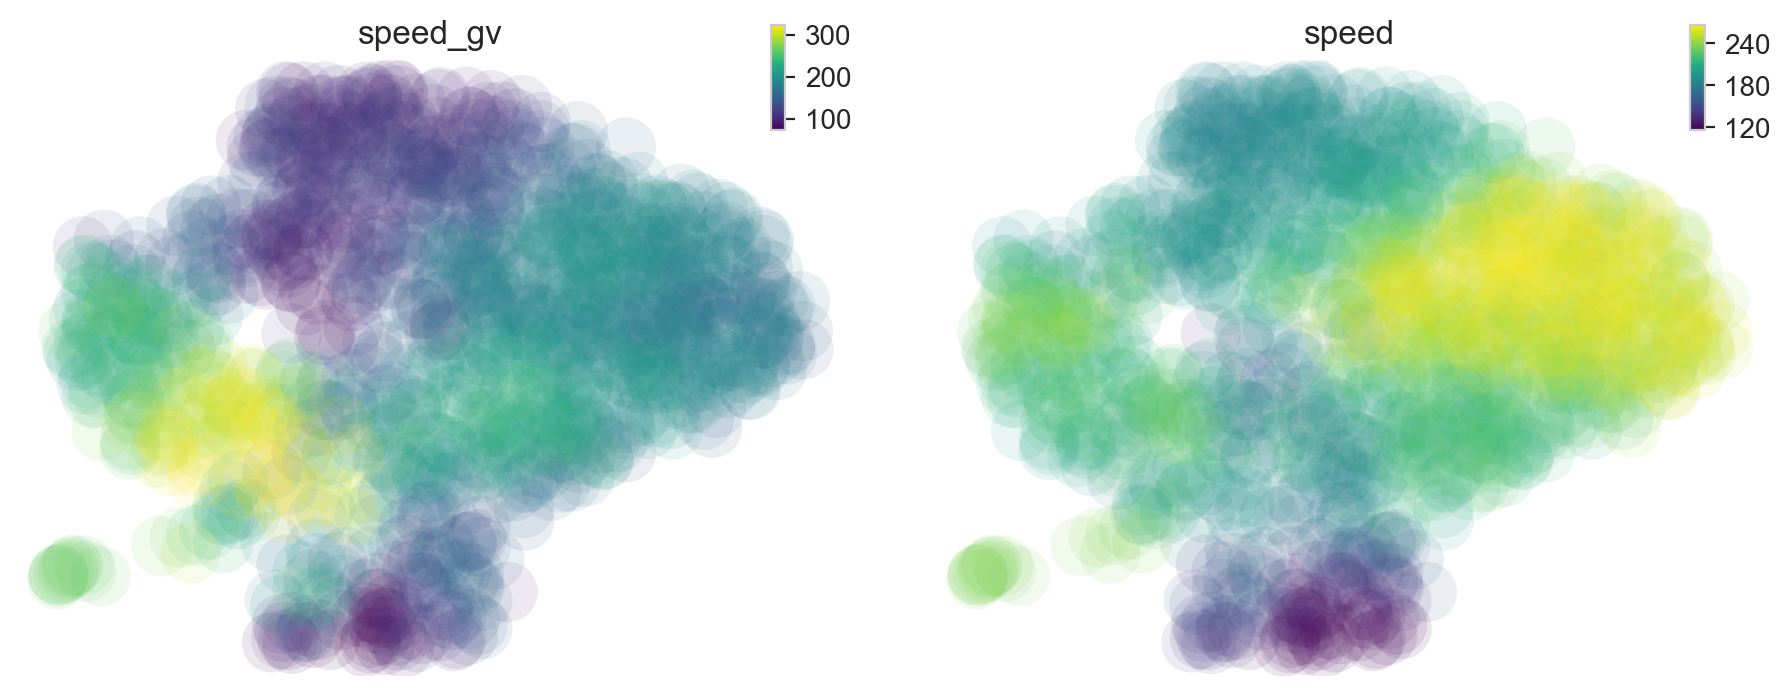

In [15]:
adata_scv.obs['speed_gv'] = np.linalg.norm(adata_scv.layers['velocity_gv'], axis=1)
adata_scv.obs['speed'] = np.linalg.norm(adata_scv.layers['velocity'], axis=1)
dyn.pl.scatters(adata_scv, color=['speed_gv', 'speed'])

In [ ]:
axis_font = {'fontname':'Arial', 'size':'14'}

In [56]:
sns.set_style('white')

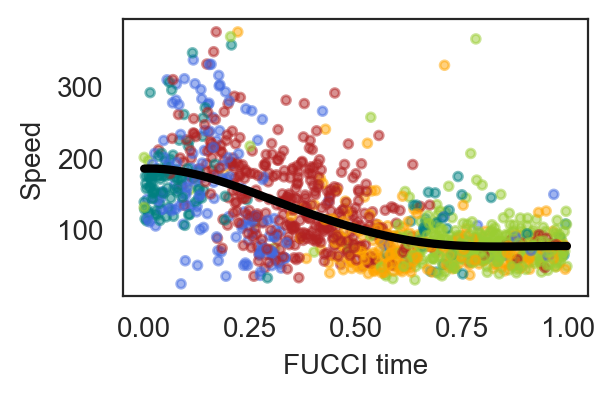

In [58]:
from pygam import LinearGAM, s
fig, ax = plt.subplots(1,1,figsize=(3,1.8))
x, y = adata_dyn.obs['fucci_time'].values, adata_dyn.obs['speed_gv'].values
term = s(0, n_splines=6, spline_order=3)
gam = LinearGAM(term, max_iter=2000, verbose=False).fit(x, y)
x_lins = np.linspace(x.min(), x.max(), 100)
y_pred = gam.predict(x_lins)
plt.scatter(x, y, c=adata_dyn.obs['cell_cycle_phase'].map(cmap), s=10, alpha=0.5)
plt.plot(x_lins, y_pred, linewidth=3, color='black')
plt.xlabel("FUCCI time")
plt.ylabel("Speed")
plt.savefig(dpi=300, transparent=True, fname=f'./figures/fucci_gv_dyn_speed_trend.pdf', bbox_inches = "tight")
plt.show()

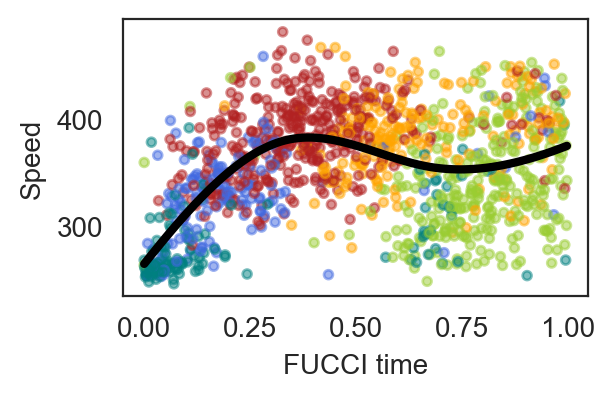

In [59]:
fig, ax = plt.subplots(1,1,figsize=(3,1.8))
x, y = adata_dyn.obs['fucci_time'].values, adata_dyn.obs['speed'].values
term = s(0, n_splines=6, spline_order=3)
gam = LinearGAM(term, max_iter=2000, verbose=False).fit(x, y)
x_lins = np.linspace(x.min(), x.max(), 100)
y_pred = gam.predict(x_lins)
plt.scatter(x, y, c=adata_dyn.obs['cell_cycle_phase'].map(cmap), s=10, alpha=0.5)
plt.plot(x_lins, y_pred, linewidth=3, color='black')
plt.xlabel("FUCCI time")
plt.ylabel("Speed")
plt.savefig(dpi=300, transparent=True, fname=f'./figures/fucci_dyn_speed_trend.pdf', bbox_inches = "tight")
plt.show()

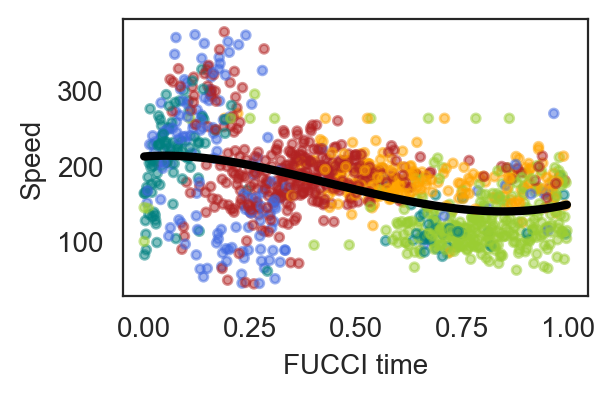

In [60]:
fig, ax = plt.subplots(1,1,figsize=(3,1.8))
x, y = adata_scv.obs['fucci_time'].values, adata_scv.obs['speed_gv'].values
term = s(0, n_splines=6, spline_order=3)
gam = LinearGAM(term, max_iter=2000, verbose=False).fit(x, y)
x_lins = np.linspace(x.min(), x.max(), 100)
y_pred = gam.predict(x_lins)
plt.scatter(x, y, c=adata_scv.obs['cell_cycle_phase'].map(cmap), s=10, alpha=0.5)
plt.plot(x_lins, y_pred, linewidth=3, color='black')
plt.xlabel("FUCCI time")
plt.ylabel("Speed")
plt.savefig(dpi=300, transparent=True, fname=f'./figures/fucci_gv_scv_speed_trend.pdf', bbox_inches = "tight")
plt.show()

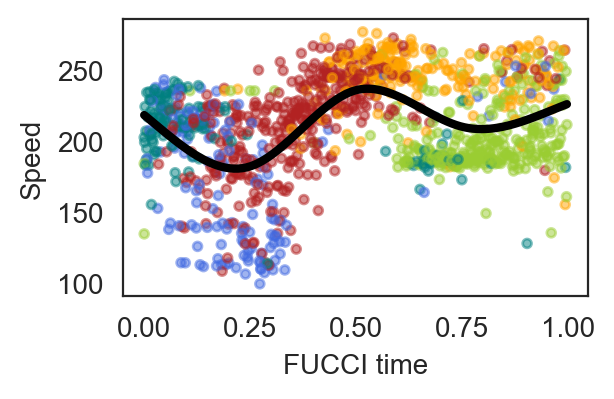

In [61]:
fig, ax = plt.subplots(1,1,figsize=(3,1.8))
x, y = adata_scv.obs['fucci_time'].values, adata_scv.obs['speed'].values
term = s(0, n_splines=7, spline_order=3)
gam = LinearGAM(term, max_iter=2000, verbose=False).fit(x, y)
x_lins = np.linspace(x.min(), x.max(), 100)
y_pred = gam.predict(x_lins)
plt.scatter(x, y, c=adata_scv.obs['cell_cycle_phase'].map(cmap), s=10, alpha=0.5)
plt.plot(x_lins, y_pred, linewidth=3, color='black')
plt.xlabel("FUCCI time")
plt.ylabel("Speed")
plt.savefig(dpi=300, transparent=True, fname=f'./figures/fucci_scv_speed_trend.pdf', bbox_inches = "tight")
plt.show()

# UMI trend

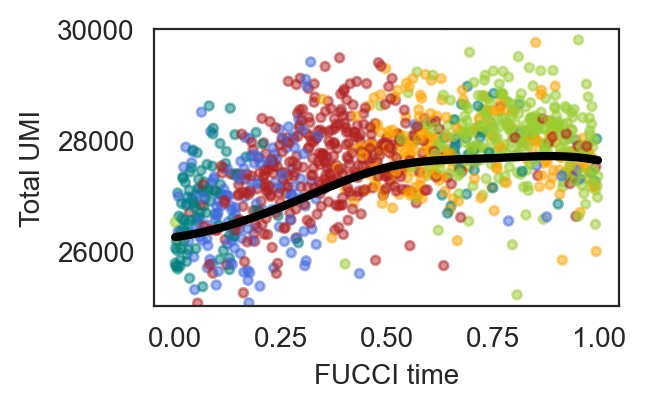

In [62]:
fig, ax = plt.subplots(1,1,figsize=(3,1.8))
x, y = adata_dyn.obs['fucci_time'].values, adata_dyn.X.sum(1)
term = s(0, n_splines=7, spline_order=3)
gam = LinearGAM(term, max_iter=2000, verbose=False).fit(x, y)
x_lins = np.linspace(x.min(), x.max(), 100)
y_pred = gam.predict(x_lins)
plt.scatter(x, y, c=adata_dyn.obs['cell_cycle_phase'].map(cmap), s=10, alpha=0.5)
plt.plot(x_lins, y_pred, linewidth=3, color='black')
plt.xlabel("FUCCI time")
plt.ylabel("Total UMI")
plt.ylim([25000,30000])
plt.savefig(dpi=300, transparent=True, fname=f'./figures/fucci_umi_trend.pdf', bbox_inches = "tight")
plt.show()